In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D

2023-11-23 10:28:40.029962: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 10:28:40.045119: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 10:28:40.159970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 10:28:40.160215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 10:28:40.187395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
url_train = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/train.csv'
url_val = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/val.csv'
url_test = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/test.csv'

df_train = pd.read_csv(url_train, index_col=0)
df_val = pd.read_csv(url_val, index_col=0)
df_test = pd.read_csv(url_test, index_col=0)

In [4]:
class DataWindow:
    def __init__(self, input_width, label_width, shift, df_train, df_val, df_test, label_columns=None):
        # window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        
        # データ
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        
        # ラベル
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(self.df_train.columns)}
        
        # スライス
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        # ラベル開始位置
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def plot(self, plot_col: str, model=None, max_subplots=3):
        inputs, labels = self.sample_batch
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        n_max = min(max_subplots, len(inputs))
        
        for n in range(n_max):
            plt.subplot(n_max, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            
            if label_col_index is None:
                continue
            
            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='tab:green', s=64)
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='tab:red', s=64)
            
            if n == 0:
                plt.legend()
        plt.xlabel('Time (h)')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.df_train)
    
    @property
    def val(self):
        return self.make_dataset(self.df_val)
    
    @property
    def test(self):
        return self.make_dataset(self.df_test)
    
    @property
    def sample_batch(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [5]:
# for training
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(),
        metrics=[MeanAbsoluteError()]
    )
    history = model.fit(
        window.train,
        epochs=max_epochs,
        validation_data=window.val,
        callbacks=[early_stopping]
    )
    return history

In [6]:
# models
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                res = inputs[:, :, index]
                res = res[:, :, tf.newaxis]
                tensors.append(res)
            return tf.concat(tensors, axis=-1)
        else:
            res = inputs[:, :, self.label_index]
            return res[:, :, tf.newaxis]

class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])
    
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

# 線形モデル
ms_linear = Sequential([Dense(units=1, kernel_initializer=tf.initializers.zeros)])
# DNN
ms_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])
# LSTM
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])
# CNN
KERNEL_WIDTH = 3
ms_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])
ms_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])

In [7]:
# マルチステップ
column_indices = {name: i for i, name in enumerate(df_train.columns)}
multi_window = DataWindow(input_width=24, label_width=24, shift=24, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=['traffic_volume'])
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1
multi_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=['traffic_volume'])
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])
ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_test_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_test_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test)
ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_test_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test)
history = compile_and_fit(ms_linear, multi_window)
ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_test_performance['Linear'] = ms_linear.evaluate(multi_window.test)
history = compile_and_fit(ms_dense, multi_window)
ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_test_performance['Dense'] = ms_dense.evaluate(multi_window.test)
history = compile_and_fit(ms_lstm_model, multi_window)
ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_test_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test)
history = compile_and_fit(ms_cnn_model, multi_conv_window)
ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.val)
ms_test_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.test)
history = compile_and_fit(ms_cnn_lstm_model, multi_conv_window)
ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.val)
ms_test_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.test)

54/54 [==============================] - 0s 2ms/step - loss: 0.2018 - mean_absolute_error: 0.3413
Epoch 1/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0897 - mean_absolute_error: 0.2464 - val_loss: 0.0457 - val_mean_absolute_error: 0.1821
Epoch 2/50
383/383 [==============================] - 1s 4ms/step - loss: 0.0297 - mean_absolute_error: 0.1365 - val_loss: 0.0262 - val_mean_absolute_error: 0.1259
Epoch 3/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0200 - mean_absolute_error: 0.1043 - val_loss: 0.0213 - val_mean_absolute_error: 0.1083
Epoch 4/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0176 - mean_absolute_error: 0.0954 - val_loss: 0.0197 - val_mean_absolute_error: 0.1007
Epoch 5/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0168 - mean_absolute_error: 0.0914 - val_loss: 0.0189 - val_mean_absolute_error: 0.0961
Epoch 6/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0164 -

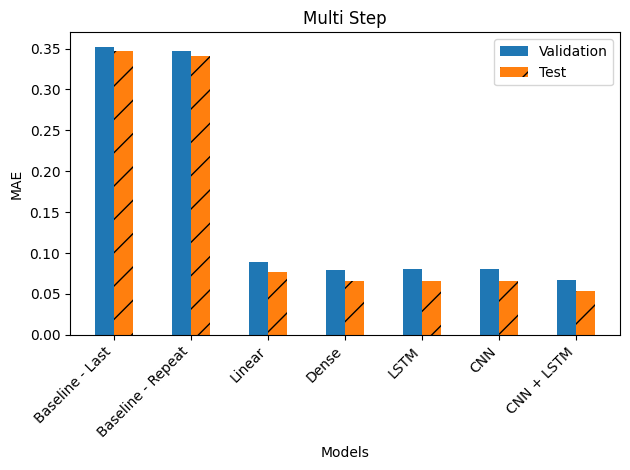

In [8]:
# multi stepの結果比較
plt.title('Multi Step')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.bar(ms_val_performance.keys(), [v[1] for v in ms_val_performance.values()], width=-0.25, align='edge', label='Validation')
plt.bar(ms_test_performance.keys(), [v[1] for v in ms_test_performance.values()], width=0.25, align='edge', label='Test', hatch='/')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

## ARLSTMアーキテクチャを調べる

## ARLSTMモデルを構築する